In [1]:
import numpy as np
import pandas as pd
import datetime
import pyarrow.parquet as pq
import os
import matplotlib.pyplot as plt

In [2]:
### Preparation:
# 1. read data file names
folder_path = "F:/volume_prediction"
filenames = os.listdir(folder_path)
filenames = [x for x in filenames if x.endswith(".parquet")]

filenames

['barra_factor_exposures.parquet',
 'earnings.parquet',
 'pricing_and_volumes.parquet',
 'r3k_sec_mapping.parquet']

In [3]:
# 2. load data
from model_training_utils import read_data
# using pyarrow.parquet.read_table to load data
# columns and filters are useful to save memory

def load_barra(factor_group, universe, folder_path):
    barra_factor_exposures_df = read_data(filename='barra_factor_exposures',
                                          filters=[('factor_group','==',factor_group)], 
                                          folder_path=folder_path)
    return universe.merge(barra_factor_exposures_df, 
                          on=["date", "barrid"], how="left", suffixes=("", "_barra"))

save_folder_path = "F:/predictors_v2"
def write_data(df, filename):
    return df.to_parquet(f"{save_folder_path}/{filename}.parquet", engine='pyarrow')

### [1] Find the universe after mapping
use the intersection of universe

In [4]:
# final universe
predictors_path = "F:/predictors"
final_universe = read_data(filename="final_universe",
                               columns=['date', 'barrid', 'isin', 'fsym_id'], 
                               folder_path=predictors_path)

In [5]:
# check the time range of the final universe
dates_list = final_universe.date.unique()
min(dates_list), max(dates_list)

(datetime.date(2019, 1, 2), datetime.date(2023, 12, 29))

### [2] Features/Predictors

### 1. Technical signals (“tech”)
From paper:  
Technical signals (“tech”): lagged moving averages of returns and log dollar volume over the past 1, 5, 22, and 252 days.
##### ++ feature from is_adj_date to earning release schedule factors

In [6]:
pv_df = read_data(filename="pricing_and_volumes",
                  columns=['date', 'barrid', 'adj_price', 'adj_volume', 'is_adj_date'], 
                  folder_path=folder_path)

pv_df = final_universe.merge(pv_df, on=['date', 'barrid'], how="left")
pv_df = pv_df.sort_values(by=["isin", "date"], ignore_index=True)
pv_df.loc[:, "adj_price"]=pv_df["adj_price"].replace(0, np.nan)
pv_df.loc[:, "log_adj_volume"]=np.log(pv_df["adj_volume"].replace(0, np.nan).replace(np.float32("inf"), np.nan))
pv_df.loc[:, "return"]=pv_df.groupby(["isin"])['adj_price'].pct_change(fill_method=None)

pv_df = pv_df[['barrid', 'date', 'isin', 'log_adj_volume', 'return', 'is_adj_date']]

In [7]:
# Build feature based on is_adj_date: 
# Assume we know some corp action in advance at least 2 days
pv_df["is_adj_date"] = pv_df.is_adj_date.astype(int)
pv_df.loc[:, "before_adj_date"] = pv_df.groupby("isin")['is_adj_date'].shift(-1).fillna(0) + pv_df.groupby("isin")['is_adj_date'].shift(-2).fillna(0)
pv_df.loc[:, "on_after_adj_date"] = pv_df.groupby("isin")['is_adj_date'].shift(1).fillna(0) + pv_df.groupby("isin")['is_adj_date'].shift(2).fillna(0)
pv_df.loc[:, "on_after_adj_date"] += pv_df.loc[:, "is_adj_date"]

In [8]:
# Use log return instead of return
pv_df['return'] = pv_df['return'].clip(lower=-1, upper=1)
pv_df['logret'] = np.log(pv_df['return']+1)

pv_df.loc[:, "logret_ma1"]=pv_df.groupby("isin")['logret'].ffill()
pv_df.loc[:, "logret_ma5"]=pv_df.groupby("isin")['logret'].ffill().rolling(5).mean()
pv_df.loc[:, "logret_ma22"]=pv_df.groupby("isin")['logret'].ffill().rolling(22).mean()
pv_df.loc[:, "logret_ma252"]=pv_df.groupby("isin")['logret'].ffill().rolling(252).mean()

# log vol is the same
pv_df.loc[:, "logvol_ma1"]=pv_df.groupby("isin")['log_adj_volume'].ffill()
pv_df.loc[:, "logvol_ma5"]=pv_df.groupby("isin")['log_adj_volume'].ffill().rolling(5).mean()
pv_df.loc[:, "logvol_ma22"]=pv_df.groupby("isin")['log_adj_volume'].ffill().rolling(22).mean()
pv_df.loc[:, "logvol_ma252"]=pv_df.groupby("isin")['log_adj_volume'].ffill().rolling(252).mean()

(<Axes: >, <Axes: >)

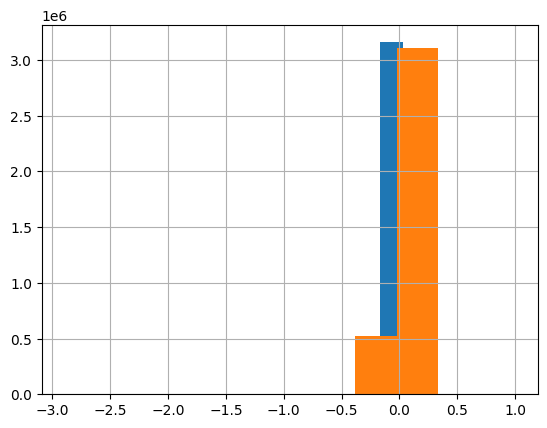

In [9]:
pv_df["return"].hist(), pv_df["logret"].hist()

In [11]:
pv_df = pv_df.drop(columns=["return","is_adj_date"])
# Drop suspicious records
# dates = [datetime.date(2019, 5, 13), datetime.date(2019, 5, 14), datetime.date(2022, 6, 27)]
# isins = ["IE00BLNN3691"]
# pv_df = pv_df[~(pv_df["isin"].isin(isins) & pv_df["date"].isin(dates))]
pv_df = pv_df[~pv_df["barrid"].isin(["GERJEF1", "GERRJO1"])]

In [12]:
# save the new tech features
write_data(pv_df, "tech")

### 2. Fundamental firm characteristics: market equity
From paper:
A small set of commonly used fundamental firm characteristics (“fund-1”): market equity, standardized earnings surprise, book leverage, book-to-market equity, Dimson beta, and firm age. (6 predictors.)

What we have: we have market equity in pricing_and_volumes_df

##### ++ 5, 22-day mean: no 252 because I need the data to pretrain

In [31]:
mkt_cap = read_data(filename="mkt_cap",
                    folder_path=predictors_path)

mkt_cap = mkt_cap.sort_values(by=["isin", "date"], ignore_index=True)

In [32]:
mkt_cap["logmkt_cap"] = np.log(mkt_cap["mkt_cap"])

mkt_cap.loc[:, "logmktcap_ma1"]=mkt_cap.groupby("isin")['logmkt_cap'].ffill()
mkt_cap.loc[:, "logmktcap_ma5"]=mkt_cap.groupby("isin")['logmkt_cap'].ffill().rolling(5).mean()
mkt_cap.loc[:, "logmktcap_ma22"]=mkt_cap.groupby("isin")['logmkt_cap'].ffill().rolling(22).mean()

In [33]:
mkt_cap = mkt_cap.drop(columns=['mkt_cap'])
# Drop suspicious records
# dates = [datetime.date(2019, 5, 13), datetime.date(2019, 5, 14), datetime.date(2022, 6, 27)]
# isins = ["IE00BLNN3691"]
# mkt_cap = mkt_cap[~(mkt_cap["isin"].isin(isins) & mkt_cap["date"].isin(dates))]
mkt_cap = mkt_cap[~mkt_cap["barrid"].isin(["GERJEF1", "GERRJO1"])]

In [34]:
# Save the new market cap features
write_data(mkt_cap, "mkt_cap")

### 3. Style and industry factors
From paper:
The remaining firm characteristics from the JKP dataset (“fund-2”), which are merged and transformed in the same way as fund-1 variables. (147 predictors.)

What we have: barra factor

##### ++5, 22: no 252 because I need the data to pretrain

#### (1). Style factors
factor_group = '1-Risk Indices': each barrid should have a value for each factor each date

In [6]:
# Load style factors
style_factors = load_barra('1-Risk Indices', universe = final_universe, folder_path=folder_path)
# Transform it into the format [date, isin, factors...]
# which the machine learning model can use directly
style_factors = pd.pivot_table(style_factors, index=["date", "isin"], columns=["factor"], values="exposure",
                               observed=True).reset_index().drop(columns=["EFMUSATRD_CARBONEFF"])

In [ ]:
# data range:
style_factors.describe().loc[["min", "max"]].T

<Axes: >

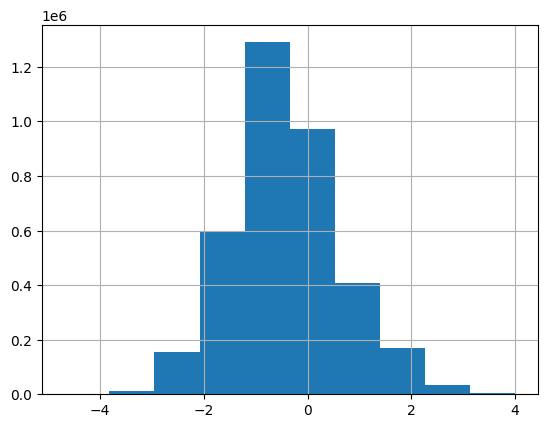

In [10]:
# example to show the distribution
style_factors["EFMUSATRD_PROFIT"].hist()

In [9]:
# remove "EFMUSATRD_" in the factor name
style_factor_names = style_factors.columns[2:] # the first two are dates and ids. drop them

new_style_factors = style_factors[["isin", "date"]].copy()
for factor_name in style_factor_names:
    for ma_num in [1,5,22]:
        new_style_factors.loc[:, f'{factor_name.split("_")[1]}_ma{ma_num}'] = style_factors.groupby("isin")[factor_name].ffill().rolling(ma_num).mean()

In [10]:
# Save the style factor features
write_data(new_style_factors, "style_factors")

#### (2). Industry factors
factor_group = '2-Industries': each barrid should be classified into at least one industry

format: one-hot * exposure value
##### ++ aggregation values based on the industry with the largest exposure value

In [6]:
## Part 1: no change
# Load industry factors
# https://medium.com/bcggamma/a-better-way-forecasting-with-embeddings-8f45e7065f2b
industry_factors = load_barra('2-Industries', universe = final_universe, folder_path=folder_path)
# Transform it into the format [date, isin, factors...]
# which the machine learning model can use directly
# Method: use dummpy variable and also contain the info of exposure
industry_factors = pd.pivot_table(industry_factors, index=["date", "isin"], columns=["factor"], 
                                  values="exposure", observed=True).reset_index().fillna(0)

In [ ]:
# data range: no negative values
industry_factors.describe().loc[["min", "max"]].T

In [7]:
# remove "EFMUSATRD_" in the factor name
industry_factors.columns = list(industry_factors.columns[:2]) + [factor_name.split("_")[1] for factor_name in industry_factors.columns[2:]]

In [ ]:
# Save the industry factor features
write_data(industry_factors, "industry_factors")

In [14]:
# Part 2: aggregation
ind_cols=['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
       'BANKS', 'BEVTOB', 'BIOLIFE', 'BLDGPROD', 'CHEM', 'CNSTENG', 'CNSTMACH',
       'CNSTMATLPAPER', 'COMMEQP', 'COMPELEC', 'COMSVCS', 'CONGLOM',
       'CONTAINR', 'DISTRIB', 'DIVFIN', 'ELECEQP', 'ELECUTIL', 'ENERGYEQ',
       'FOODPROD', 'FOODRET', 'GASUTIL', 'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG',
       'HOUSEDUR', 'INDMACH', 'INSURNCE', 'INTERNET', 'LEISPROD', 'LEISSVCS',
       'LIFEINS', 'MEDIA', 'MGDHLTH', 'MULTUTIL', 'NETRET', 'OILGSCON',
       'OILGSEXP', 'PHARMA', 'PRECMTLS', 'PSNLPROD', 'REALEST', 'RESTAUR',
       'RLESTMNG', 'ROADRAIL', 'SEMICOND', 'SEMIEQP', 'SOFTWARE', 'SPLTYRET',
       'SPTYCHEM', 'SPTYSTOR', 'TELECOM', 'TRADECO', 'TRANSPRT']

industry_factors_new=industry_factors[["date", "isin"]].copy()
# Find the indutrsy with the laregst exposure for each stock
industry_factors_new["idxmax"] = industry_factors[ind_cols].idxmax(axis=1)
# Get the indutrsy exposure with the laregst value for each stock
industry_factors_new["max_ind_exposure"]=industry_factors[ind_cols].max(axis=1)

In [11]:
# load other datasets for aggregation
tech_df = read_data(filename="tech", columns=["date", "isin", 'logvol_ma1',  'logvol_ma5', 
                                              'logvol_ma22', 'logvol_ma252'], folder_path=save_folder_path)

style_df = read_data(filename="style_factors", columns=["date", "isin", 'SIZE_ma1', 'SIZE_ma5', 'SIZE_ma22'], 
                     folder_path=save_folder_path)

mkt_cap_df = read_data(filename="mkt_cap", columns=["date", "isin", 'logmktcap_ma1', 'logmktcap_ma5',
                                                   'logmktcap_ma22', 'logmktcap_ma252'], folder_path=save_folder_path)

In [ ]:
# get aggreagtion values of the industry with the largest exposure for each stock
def agg_industry_factors(industry_factors, predictor_df, col_names):
    df = industry_factors.merge(predictor_df, on=["date", "isin"], how="left")
    
    industry_factors_agg = df.groupby(["date", "idxmax"])[col_names].mean().reset_index()
    industry_factors_agg.columns=['date', 'idxmax'] + [f"indavg_{i}" for i in col_names]

    industry_factors_agg2 = df.groupby(["date", "idxmax"])[col_names].std().reset_index()
    industry_factors_agg2.columns=['date', 'idxmax'] + [f"indstd_{i}" for i in col_names]
    
    industry_factors_agg2 = df.groupby(["date", "idxmax"])[col_names].std().reset_index()
    industry_factors_agg2.columns=['date', 'idxmax'] + [f"indstd_{i}" for i in col_names]
    
    return industry_factors_agg.merge(industry_factors_agg2, on=["date", "idxmax"], how="left")
    
industry_factors_agg = agg_industry_factors(industry_factors_new, tech_df, ['logvol_ma1', 'logvol_ma5', 'logvol_ma22', 'logvol_ma252'])
industry_factors_agg2 = agg_industry_factors(industry_factors_new, style_df, ['SIZE_ma1', 'SIZE_ma5', 'SIZE_ma22'])
industry_factors_agg3 = agg_industry_factors(industry_factors_new, mkt_cap_df, ['logmktcap_ma1', 'logmktcap_ma5', 'logmktcap_ma22', 'logmktcap_ma252'])

industry_factors_agg = industry_factors_agg.merge(industry_factors_agg2, on=["date", "idxmax"], how="left")
industry_factors_agg = industry_factors_agg.merge(industry_factors_agg3, on=["date", "idxmax"], how="left")

In [39]:
# Merge the largest expsoure valud and the aggregation values of the industry
industry_factors_new = industry_factors_new[["date", "isin", "max_ind_exposure", "idxmax"]].merge(industry_factors_agg,
                                                                       on=["date", "idxmax"],
                                                                       how="left")

In [42]:
industry_factors_new = industry_factors_new[['date', 'isin', 'max_ind_exposure', 'indavg_logvol_ma1',
                                             'indavg_logvol_ma5', 'indavg_logvol_ma22', 'indavg_logvol_ma252',
                                             'indstd_logvol_ma1', 'indstd_logvol_ma5', 'indstd_logvol_ma22',
                                             'indstd_logvol_ma252', 'indavg_SIZE_ma1', 'indavg_SIZE_ma5',
                                             'indavg_SIZE_ma22', 'indstd_SIZE_ma1', 'indstd_SIZE_ma5',
                                             'indstd_SIZE_ma22', 'indavg_logmktcap_ma1', 'indavg_logmktcap_ma5',
                                             'indavg_logmktcap_ma22', 'indavg_logmktcap_ma252',
                                             'indstd_logmktcap_ma1', 'indstd_logmktcap_ma5', 'indstd_logmktcap_ma22',
                                             'indstd_logmktcap_ma252', 'idxmax']]

In [43]:
# Save the aggregation industry factor features
write_data(industry_factors_new, "agg_industry_factors")

### 4. Calendar dates with large effects on trading volume (“calendar”)
From paper:
We hard code four binary features based on the dates of the following four types of events.
- Early closing days for the exchanges (July 3rd, Black Friday, Christmas Eve, and New Year’s Eve).
- Triple witching days (four times a year when the index futures contract expires at the same time as the index option contract and single stocks options).
- Double witching days (eight times a year when two of the three events above, the single stock options and index options expiration, coincide).
- Russell index re-balancing (once a year, the fourth Friday in June).
  
Early closing days have substantially less trading volume, while the other three are associated with positive spikes in trading volume.
##### ++ indicators for dates before and after these special dates.

In [63]:
calendar_date = read_data(filename="calendar_date",
                          folder_path=predictors_path)

In [ ]:
calendar_date.head()

# This is a synthetic example following the structure of event-based data.
# No proprietary data is included.

# | early_close  | triple_witch | double_witch | russell_rebalance | date       | barrid   | isin         |
# |--------------|--------------|--------------|-------------------|------------|----------|--------------|
# | 0            | 0            | 0            | 0                 | 2019-01-02 | USAXXX1  | XX0000000001 |
# | 0            | 0            | 0            | 0                 | 2019-01-02 | USAXXX2  | XX0000000002 |
# | 0            | 0            | 0            | 0                 | 2019-01-02 | USAXXX3  | XX0000000003 |
# | 0            | 0            | 0            | 0                 | 2019-01-02 | USAXXX4  | XX0000000004 |
# | 0            | 0            | 0            | 0                 | 2019-01-02 | USAXXX5  | XX0000000005 |


In [66]:
# witch date
calendar_date["witch_date"] = calendar_date["triple_witch"]+calendar_date["double_witch"]
calendar_date = calendar_date[['date', 'barrid', 'isin', 'witch_date', 'early_close', 'russell_rebalance']]
calendar_date.loc[:, "before_witch"] = calendar_date.groupby("isin")['witch_date'].shift(-1).fillna(0) + calendar_date.groupby("isin")['witch_date'].shift(-2).fillna(0)
calendar_date.loc[:, "on_after_witch"] = calendar_date.groupby("isin")['witch_date'].shift(1).fillna(0) + calendar_date.groupby("isin")['witch_date'].shift(2).fillna(0)
calendar_date.loc[:, "on_after_witch"] += calendar_date["witch_date"]

In [67]:
# early close date
calendar_date.loc[:, "before_early_close"] = calendar_date.groupby("isin")['early_close'].shift(-1).fillna(0) + calendar_date.groupby("isin")['early_close'].shift(-2).fillna(0)
calendar_date.loc[:, "on_after_early_close"] = calendar_date.groupby("isin")['early_close'].shift(1).fillna(0) + calendar_date.groupby("isin")['early_close'].shift(2).fillna(0)
calendar_date.loc[:, "on_after_early_close"] += calendar_date["early_close"]

In [68]:
# russell rebalance
calendar_date.loc[:, "before_rebalance"] = calendar_date.groupby("isin")['russell_rebalance'].shift(-1).fillna(0) + calendar_date.groupby("isin")['russell_rebalance'].shift(-2).fillna(0)
calendar_date.loc[:, "on_after_rebalance"] = calendar_date.groupby("isin")['russell_rebalance'].shift(1).fillna(0) + calendar_date.groupby("isin")['russell_rebalance'].shift(2).fillna(0)
calendar_date.loc[:, "on_after_rebalance"] += calendar_date["russell_rebalance"]

In [72]:
# cast type into int
calendar_date.loc[:, ['before_witch', 'on_after_witch', 
                      'before_early_close', 'on_after_early_close', 
                      'before_rebalance', 'on_after_rebalance']] = calendar_date[['before_witch', 'on_after_witch', 
                                                                                  'before_early_close', 'on_after_early_close', 
                                                                                  'before_rebalance', 'on_after_rebalance']].astype(int)

In [73]:
# remove other columns
calendar_date=calendar_date[['date', 'barrid', 'isin', 'before_witch', 'on_after_witch', 
                             'before_early_close', 'on_after_early_close', 'before_rebalance', 'on_after_rebalance']]

In [76]:
# Save calendar feature 
write_data(calendar_date, "calendar_date")

### 5. Earnings release schedule (“earnings”): 
From paper:
We construct 10 categorical dummy variables (one hot encoding) indicating whether the firm has an upcoming earnings release or just had one in the past few days. 
- We first construct the number of days until the next known scheduled earnings release event.
  
  For example, a value of zero implies the current day is previously known to have a scheduled release. A negative value means there are no known scheduled events in the future and indicates how many days since the last event.
- We convert this number into 10 dummy variables of categorical bins: ≤ −4,−3,−2,−1,0,1,2,3,4,≥ 5. The data source is the Capital IQ Key Developments dataset. (10 predictors.)
##### From ['lag_-1', 'lag_-2', 'lag_-3', 'lag_0', 'lag_1', 'lag_2', 'lag_3', 'lag_-4', 'lag_≥5'] To ['≤-3', '-1_2', '0', '1_2', '≥3']


In [78]:
# Load earning calendar data in the final universe
release_schedule = read_data(filename="release_schedule",
                             folder_path=predictors_path)

In [80]:
# merge 3,4,>=5 into >=3 
release_schedule['≥3']=release_schedule['3']+ release_schedule['4']+ release_schedule['≥5']
# merge 1,2 into 1_2
release_schedule['1_2']=release_schedule['1']+ release_schedule['2']

In [81]:
# merge -3,<=-4 into <=-3 
release_schedule['≤-3']=release_schedule['-3']+ release_schedule['≤-4']
# merge -1,-2 into -1_2
release_schedule['-1_2']=release_schedule['-1']+ release_schedule['-2']

In [86]:
release_schedule=release_schedule[['date', 'isin', '≤-3', '-1_2', '0', '1_2', '≥3']]

In [ ]:
release_schedule.head()
# # This is a synthetic example following the structure of stock factor exposure data.
# # No proprietary data is included.

# | date       | isin           | ≤-3 | -1_2 | 0   | 1_2 | ≥3  |
# |------------|----------------|-----|------|-----|-----|-----|
# | 2019-01-02 | xxxxxxxxxxx1   | 0.0 | 0.0  | 0.0 | 0.0 | 1.0 |
# | 2019-01-02 | xxxxxxxxxxx2   | 0.0 | 0.0  | 0.0 | 0.0 | 1.0 |
# | 2019-01-02 | xxxxxxxxxxx3   | 0.0 | 0.0  | 0.0 | 0.0 | 1.0 |
# | 2019-01-02 | xxxxxxxxxxx4   | 0.0 | 0.0  | 0.0 | 0.0 | 1.0 |
# | 2019-01-02 | xxxxxxxxxxx5   | 0.0 | 0.0  | 0.0 | 0.0 | 1.0 |


In [88]:
# Save earning schedule feature 
write_data(release_schedule, "release_schedule")